In [1]:
import numpy             as np
import matplotlib.pyplot as plt

from dfdjaxGP import JaxDerviativeGP

/Users/mikegros/opt/anaconda3/envs/jaxgp/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
n  = 20
pn = 50

x = np.random.rand(n)

y = np.exp(-x*2)*np.sin(x*2.*np.pi)

px = np.linspace(0,1,pn)
py = np.exp(-px*2)*np.sin(px*2.*np.pi)

# JaxDerivativeGP with Bayesian inference for correlation length and marginal variance

- To account for uncertainty in these GP hyperparameters, I've set the code up to use numpyro to sample these parameters using HMC. This is pretty fast, not more than 10 or 20 seconds in my toy problems here

- Prediction is currently very slow however. I need to JIT some of the prediction functions to try to speed that up, but right now it is slow to loop through the 4000 samples and sample from the GP for each case.

In [3]:
jgp = JaxDerviativeGP(x, y)


In [ ]:
def model(X, y, deriv):
    # set uninformative log-normal priors on our three kernel hyperparameters
    var    = numpyro.sample("marg_var", dist.LogNormal(0.0, 1.0))
    length = numpyro.sample("corr_len", dist.LogNormal(0.0, 1.0))

    # compute kernel
    k  = jgp.get_cov_mat(X, X, length, var)
    k += np.eye(X.shape[0])*1.e-4

    # sample Y according to the standard gaussian process formula
    numpyro.sample(
        "Y",
        dist.MultivariateNormal(loc=jnp.zeros(X.shape[0]), covariance_matrix=k),
        obs=y,
    )

rng_key, rng_key_predict = random.split(random.PRNGKey(0))
init_strategy = init_to_median(num_samples=10)
kernel        = NUTS(model, init_strategy=init_strategy)
mcmc = MCMC(
        kernel,
        num_warmup   = n_warmup,
        num_samples  = n_samples,
        num_chains   = n_chains,
        progress_bar = True,
    )
mcmc.run(rng_key, jgp.train_X, jgp.train_y)
mcmc.print_summary()
self.samples = mcmc.get_samples() 

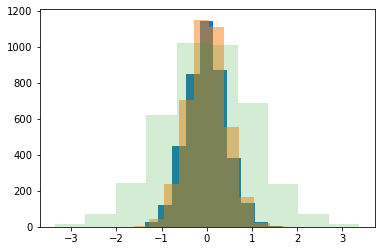

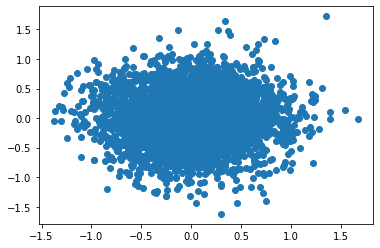

In [4]:
plt.hist(np.log10(np.array(jgp.samples["corr_len"])))
plt.hist(np.log10(np.array(jgp.samples["marg_var"])),alpha=0.5)
plt.hist(np.random.randn(4000), alpha=0.2)
plt.show()

plt.scatter(np.log10(np.array(jgp.samples["corr_len"])), np.log10(np.array(jgp.samples["marg_var"])))


In [5]:
%%time
preds, y_hat, lower, upper = jgp.bayes_predict(px)


This is currently really slow - 
 a minute or two for predicting 50 points from 4000 samples with 20 observations.
Just a heads up.
CPU times: user 43.3 s, sys: 211 ms, total: 43.5 s
Wall time: 43.7 s


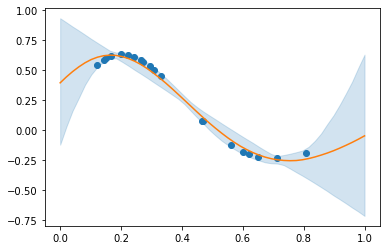

In [6]:
plt.scatter(x, y,c="C0")
plt.plot(px, y_hat, c="C1")
plt.fill_between(px, lower, upper, alpha=0.2, color="C0")
plt.show()


In [7]:
%%time
preds, y_hat, lower, upper = jgp.bayes_predict(px, derivative="df/dx")


This is currently really slow - 
 a minute or two for predicting 50 points from 4000 samples with 20 observations.
Just a heads up.
CPU times: user 1min 58s, sys: 457 ms, total: 1min 58s
Wall time: 1min 58s


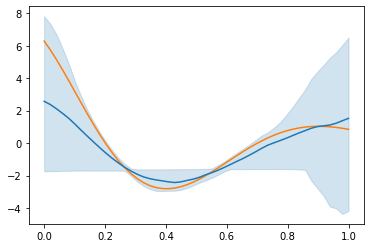

CPU times: user 101 ms, sys: 3.68 ms, total: 105 ms
Wall time: 103 ms


In [8]:
%%time
plt.plot(px, -2*np.exp(-2*px)*np.sin(px*2.*np.pi) + np.exp(-2*px)*np.cos(px*2.*np.pi)*2*np.pi, c="C1")
plt.plot(px, y_hat, c="C0")
plt.fill_between(px, lower, upper, alpha=0.2, color="C0")
plt.show()


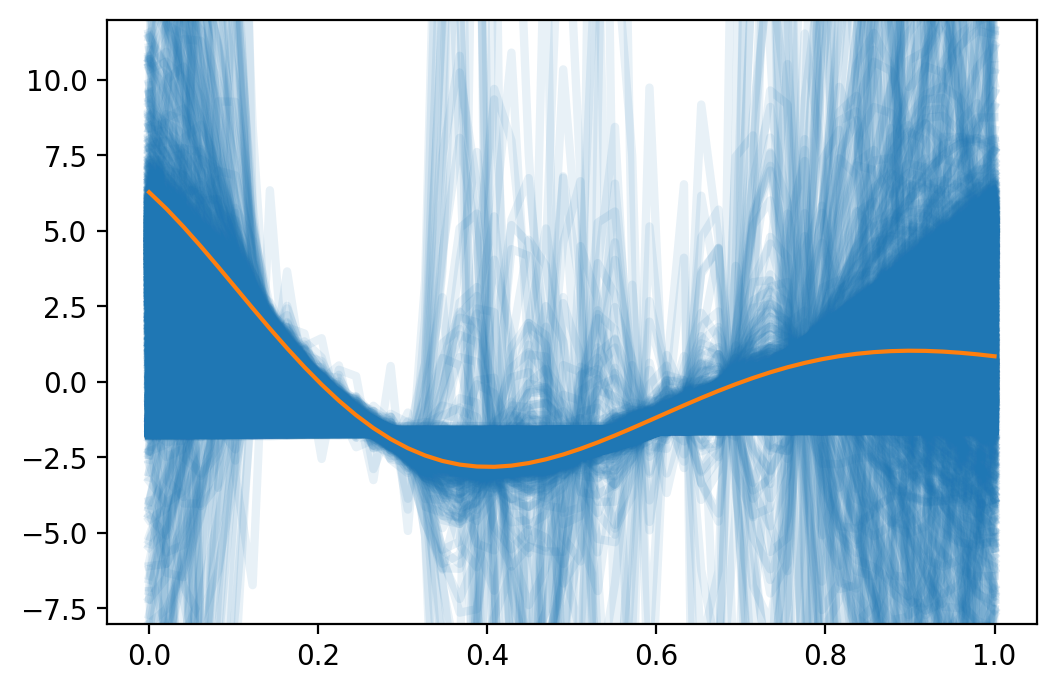

CPU times: user 4.28 s, sys: 46.7 ms, total: 4.32 s
Wall time: 4.38 s


In [9]:
%%time
plt.figure(dpi=200)
plt.plot(px, preds.T, c="C0", alpha=0.1, linewidth=3)
plt.plot(px, -2*np.exp(-2*px)*np.sin(px*2.*np.pi) + np.exp(-2*px)*np.cos(px*2.*np.pi)*2*np.pi, c="C1")
plt.ylim(-8,12)
plt.show()


In [10]:
%%time
preds, y_hat, lower, upper = jgp.bayes_predict(px, derivative="d2f/dx2")


This is currently really slow - 
 a minute or two for predicting 50 points from 4000 samples with 20 observations.
Just a heads up.
CPU times: user 5min 50s, sys: 1.37 s, total: 5min 51s
Wall time: 5min 52s


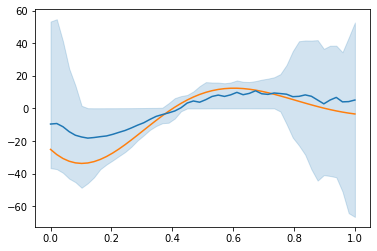

In [11]:
plt.plot(px, 4*np.exp(-2*px)*np.sin(px*2.*np.pi) + 
         -4*np.pi*np.exp(-2*px)*np.cos(px*2.*np.pi) + 
         -2*np.exp(-2*px)*np.cos(px*2.*np.pi)*2*np.pi - 
         np.exp(-2*px)*np.sin(px*2.*np.pi)*4*np.pi**2, c="C1")

plt.plot(px, y_hat, c="C0")
plt.fill_between(px, lower, upper, alpha=0.2, color="C0")
plt.show()

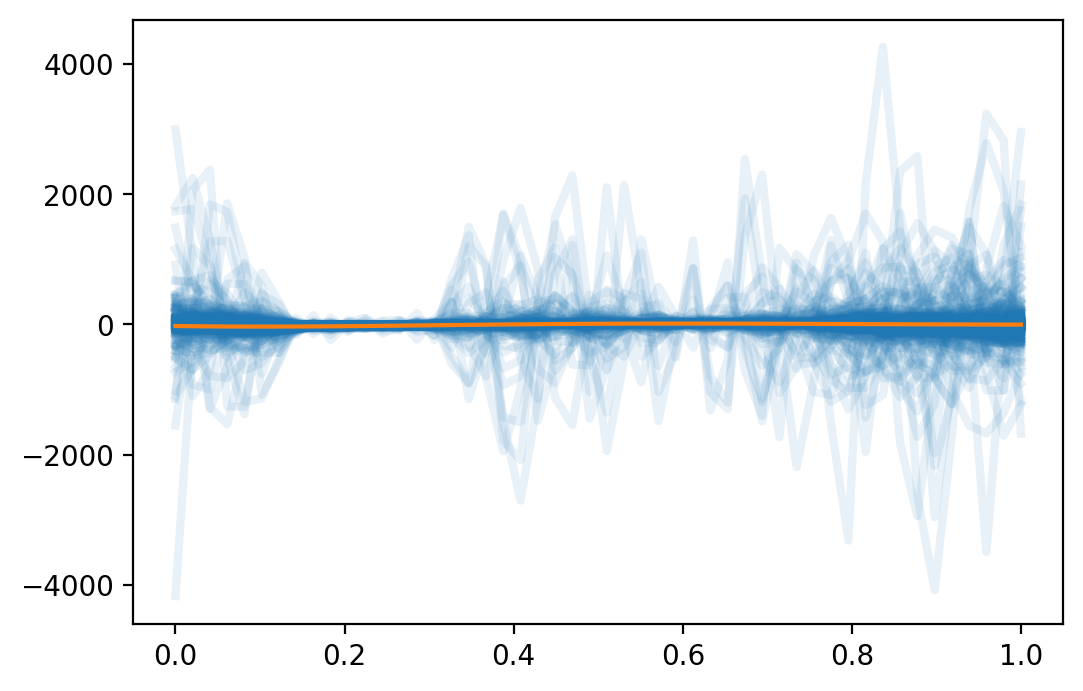

CPU times: user 3.71 s, sys: 33 ms, total: 3.74 s
Wall time: 3.74 s


In [12]:
%%time
plt.figure(dpi=200)
plt.plot(px, preds.T, c="C0", alpha=0.1, linewidth=3)
plt.plot(px, 4*np.exp(-2*px)*np.sin(px*2.*np.pi) + 
         -4*np.pi*np.exp(-2*px)*np.cos(px*2.*np.pi) + 
         -2*np.exp(-2*px)*np.cos(px*2.*np.pi)*2*np.pi - 
         np.exp(-2*px)*np.sin(px*2.*np.pi)*4*np.pi**2, c="C1")
plt.show()


In [13]:
def truef(x):
    return np.sin(x[:,0]*2 *np.pi) + x[:,1]

def truedfdx(x):
    #return -np.sin(x[:,0]*2 *np.pi)*4 *np.pi**2
    return np.cos(x[:,0]*2 *np.pi)*2 *np.pi

def truedfdy(x):
    #return 1.*np.zeros_like(x[:,0])
    return 1.*np.ones_like(x[:,0])


In [14]:
n  = 30
pn = 400

x  = np.random.rand(n,2)
pv = np.linspace(0,1,20)
px = np.array([(x, y) for x in pv for y in pv])
y  = truef(x)


In [15]:
jgp = JaxDerviativeGP(x, y)


In [16]:
jgp.bayes_train()

/Users/mikegros/Projects/Nuclei/JaxGP/derivGP/gp.py:106: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
sample: 100%|█████████████████████████| 1500/1500 [00:01<00:00, 1337.03it/s, 3 steps of size 8.61e-01. acc. prob=0.92]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  corr_len      1.59      2.00      0.99      0.04      3.46   3106.21      1.00
  marg_var      1.68      2.32      1.04      0.04      3.65   2406.97      1.00

Number of divergences: 0


In [17]:
%%time
py   = truef(px)

vmin = np.min(py)
vmax = np.max(py)

preds, y_hat, lower, upper = jgp.bayes_predict(px)


This is currently really slow - 
 a minute or two for predicting 50 points from 4000 samples with 20 observations.
Just a heads up.
CPU times: user 18min 43s, sys: 21.5 s, total: 19min 5s
Wall time: 2min 23s


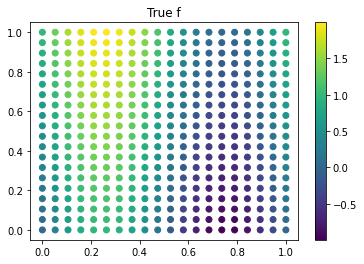

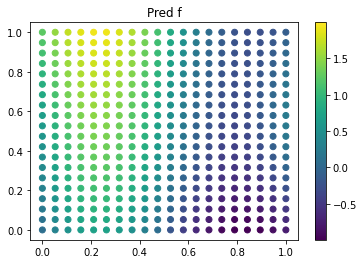

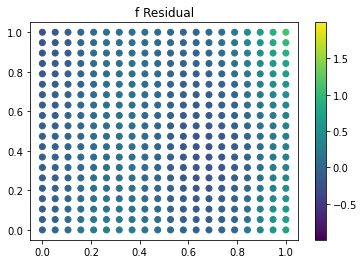

In [18]:
plt.contourf(pv, pv, py.reshape(20,20), vmin=vmin, vmax=vmax)
plt.title("True f")
plt.colorbar()
plt.show()

plt.contourf(pv, pv, y_hat.reshape(20,20), vmin=vmin, vmax=vmax)
plt.title("Pred f")
plt.colorbar()
plt.show()

plt.contourf(pv, pv, (py - y_hat).reshape(20,20), vmin=vmin, vmax=vmax)
plt.title("f Residual")
plt.colorbar()
plt.show()


In [19]:
%%time 

py   = truedfdx(px)

vmin = np.min(py)
vmax = np.max(py)

preds, y_hat, upper, lower = jgp.bayes_predict(px, derivative="df/dx")

This is currently really slow - 
 a minute or two for predicting 50 points from 4000 samples with 20 observations.
Just a heads up.
CPU times: user 32min 11s, sys: 39.1 s, total: 32min 50s
Wall time: 4min 5s


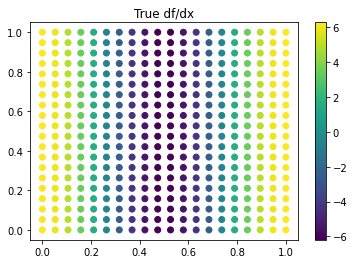

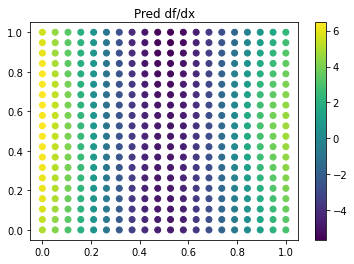

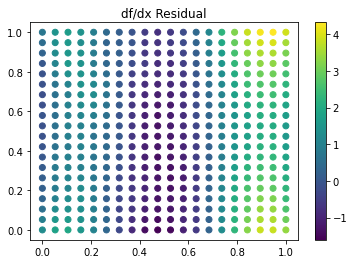

In [20]:
plt.contourf(pv, pv, py.reshape(20,20))
plt.title("True df/dx")
plt.colorbar()
plt.show()

plt.contourf(pv, pv, y_hat.reshape(20,20))
plt.title("Pred df/dx")
plt.colorbar()
plt.show()

plt.contourf(pv, pv, (py - y_hat).reshape(20,20))
plt.title("df/dx Residual")
plt.colorbar()
plt.show()


In [21]:
py   = truedfdy(px)

vmin = np.min(py)
vmax = np.max(py)

preds, y_hat, upper, lower = jgp.bayes_predict(px, derivative="df/dy")

This is currently really slow - 
 a minute or two for predicting 50 points from 4000 samples with 20 observations.
Just a heads up.


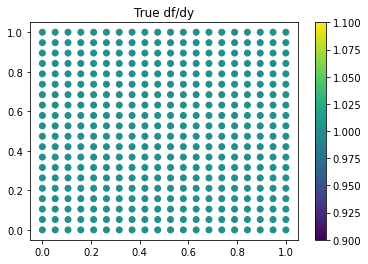

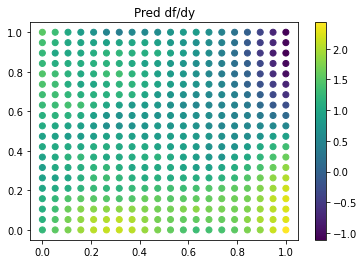

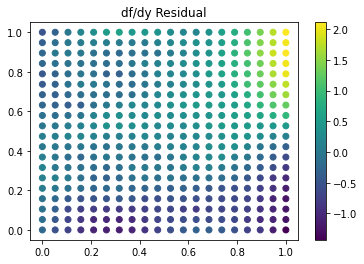

In [22]:
plt.contourf(pv, pv, py.reshape(20,20))
plt.title("True df/dy")
plt.colorbar()
plt.show()

plt.contourf(pv, pv, y_hat.reshape(20,20))
plt.title("Pred df/dy")
plt.colorbar()
plt.show()

plt.contourf(pv, pv, (py - y_hat).reshape(20,20))
plt.title("df/dy Residual")
plt.colorbar()
plt.show()
